In [1]:
import numpy as np
import sklearn
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

## Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)


![Screen%20Shot%202022-01-15%20at%2013.34.38.png](attachment:Screen%20Shot%202022-01-15%20at%2013.34.38.png)

where they consider 5 possibilities for the formation of black hole binaries: common envelope (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).

Anyway. You can find today's dataset at `solutions/formationchannels.npy`.

*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).


In [3]:
x=np.linspace(0, 5, 6)
print(x, x.shape)
print(x[np.newaxis,:], x[np.newaxis,:].shape)
print(x[:,np.newaxis], x[:,np.newaxis].shape)


[0. 1. 2. 3. 4. 5.] (6,)
[[0. 1. 2. 3. 4. 5.]] (1, 6)
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]
 [5.]] (6, 1)


Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) We'll use `sklearn.mixture.GaussianMixture`. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. Today's exercise is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in research...

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in this class.

4) For each of this fits, compute the AIC (easy! It's an attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

#### [Optional tasks, not examinable] Class labels or "responsibilities"

Class labels are a very interesting by product of a mixture analysis. What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data). 

$p(j|x_i) = \frac{a_j \mathcal{N(\mu_j,\sigma_j)}}{\sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j)}$

6) [**Optional**] Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`.


7) [**Optional**] Derive the expression above using Bayes' rule (pen and paper!)

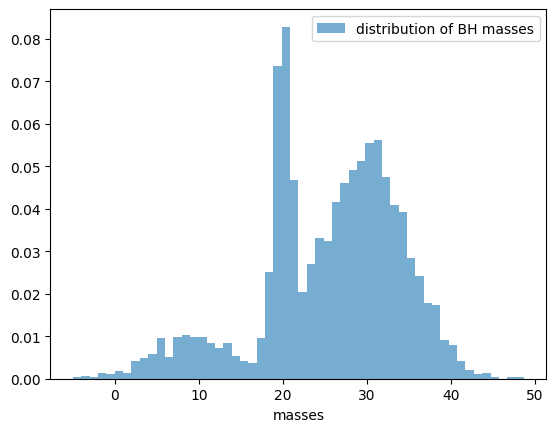

In [8]:
data = np.load("formationchannels.npy")
#print(data)
plt.hist(data, int(len(data)**0.5),  alpha=0.6, density=True, label = 'distribution of BH masses')
plt.xlabel('masses')
plt.legend()

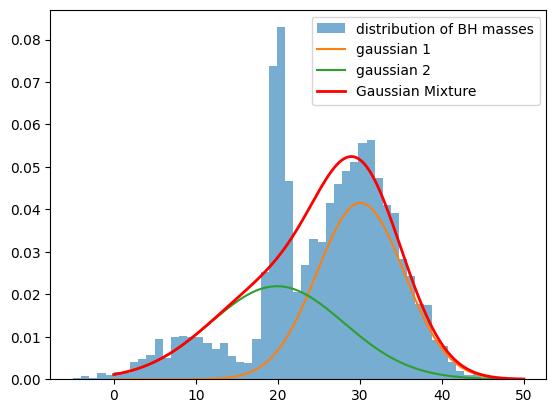

In [9]:
gm = sklearn.mixture.GaussianMixture(n_components=2, random_state=0).fit(data)
#print(gm.means_)

x= np.linspace(0, 50, 1000).reshape(-1,1)

gaussian_1 = norm.pdf(x, gm.means_[0], np.sqrt(gm.covariances_[0]))
gaussian_2 = norm.pdf(x, gm.means_[1], np.sqrt(gm.covariances_[1]))

# I then need to multiply by the weights....

plt.hist(data, int(len(data)**0.5),  alpha=0.6, density=True, label = 'distribution of BH masses')

plt.plot(x, gaussian_1* gm.weights_[0], label='gaussian 1')
plt.plot(x, gaussian_2 * gm.weights_[1],  label='gaussian 2')

plt.plot(x, np.exp(gm.score_samples(x)), label='Gaussian Mixture', color='red', linewidth=2)

plt.legend()

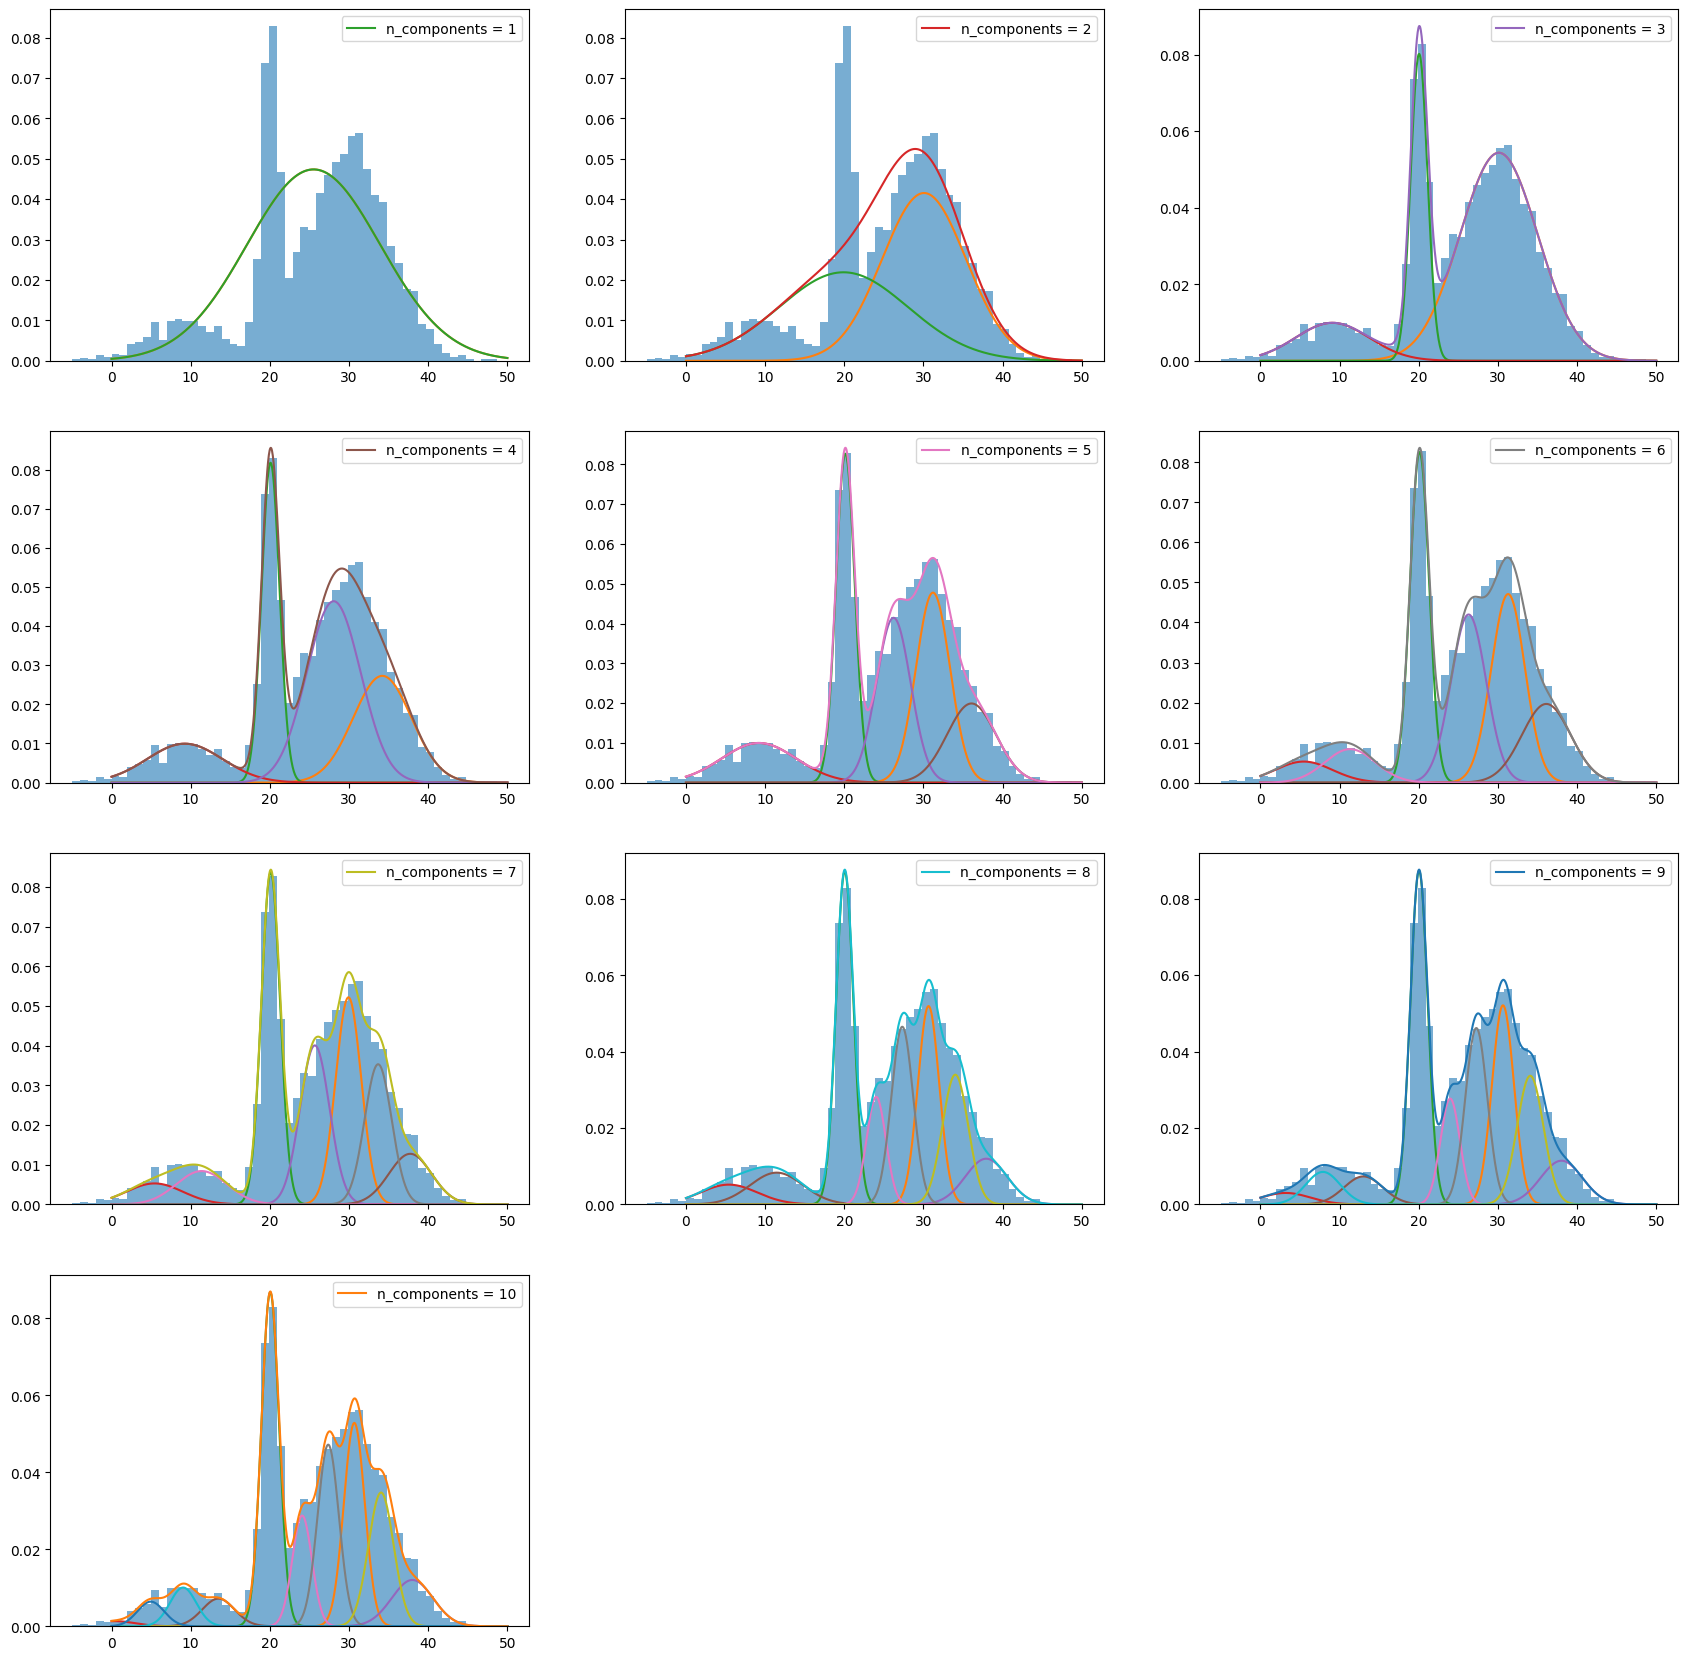

In [10]:
n_components = np.arange(1, 11)
x = np.linspace(0, 50, 1000).reshape(-1, 1)

aic = []
bic = []
fig, axes = plt.subplots(4, 3, figsize=(21, 21))


for idx, n in enumerate(n_components):

    row = idx // 3
    col = idx % 3
    ax = axes[row, col]


    gm = sklearn.mixture.GaussianMixture(n_components=n, random_state=0).fit(data)
    aic.append(gm.aic(data))
    bic.append(gm.bic(data))


    ax.hist(data, int(len(data)**0.5),  alpha=0.6, density=True)
    for i in range(n):
        gaussian = norm.pdf(x, gm.means_[i][0], np.sqrt(gm.covariances_[i][0]))


        ax.plot(x, gaussian * gm.weights_[i])
    ax.plot(x, np.exp(gm.score_samples(x)), label = 'n_components = '+str(n))
    ax.legend()
    #print(gm.score_samples(data))
    #print(gm.means_)
    #print(gm.covariances_)

#plt.tight_layout()
fig.delaxes(axes[3, 1])
fig.delaxes(axes[3, 2])

#plt.show()

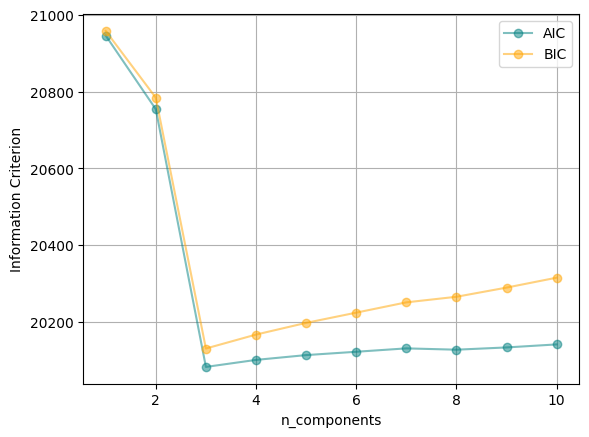

In [11]:
plt.plot(n_components, aic, color='teal',alpha=0.5, marker='o', label='AIC')
plt.plot(n_components, bic, color='orange',alpha=0.5, marker='o', label='BIC')
plt.xlabel('n_components')
plt.ylabel('Information Criterion')
plt.legend()
plt.grid()
plt.show()

the minimum AIC is obtained for: 3 components
the minimum BIC is obtained for: 3 components
weights (1000, 3)


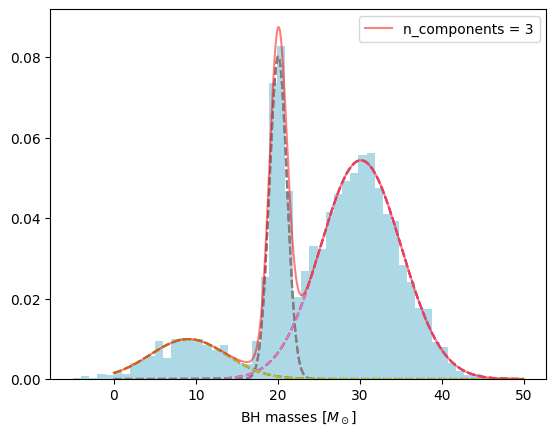

In [12]:
index_min_aic = np.argmin(aic)
index_min_bic = np.argmin(bic)
print("the minimum AIC is obtained for:", n_components[index_min_aic], "components")
print("the minimum BIC is obtained for:", n_components[index_min_bic], "components")
x = np.linspace(0, 50, 1000).reshape(-1, 1)

gm = sklearn.mixture.GaussianMixture(n_components=3, random_state=0).fit(data)

weights = gm.predict_proba(x) #before I used the method weights_, but one can also use predict_proba
print("weights", weights.shape)
gaussians = np.exp(gm.score_samples(x)).reshape(-1,1)
single_gaussian = weights * gaussians


plt.hist(data, int(len(data)**0.5), color= 'lightblue', alpha=1, density=True)

for i in range(3):
   plt.plot(x, single_gaussian, '--')

plt.plot(x, np.exp(gm.score_samples(x)),color = 'red', alpha= 0.5, label = 'n_components = '+str(3))

plt.xlabel('BH masses $[M_\odot]$')
plt.legend()

Maximum Likelihood Estimation: The Gaussian Mixture Model is fitted to your data using a technique called Maximum Likelihood Estimation (MLE). MLE aims to find the parameters of the model (including the weights, means, and covariances of the Gaussian components) that maximize the likelihood of observing the given data.
Weight Optimization: During the fitting process, the weights are adjusted to best represent the data. If one Gaussian component is a poor fit to the data, its weight will be reduced to minimize its influence on the overall model. Conversely, the weight of a well-fitting Gaussian component will be increased to reflect its greater importance in explaining the data.
Data Representation: The goal is to find a combination of Gaussian components and their weights that best represents the underlying distribution of the data. If a component is not capturing a significant portion of the data, its weight will be lowered accordingly.
In simpler terms:

Imagine you are trying to represent a group of people with different heights using two Gaussian distributions (one for shorter people and one for taller people). If there are very few very tall people in the group, the Gaussian component representing taller people will have a lower weight, reflecting their smaller proportion in the overall population.

In the context of your code:

The sklearn.mixture.GaussianMixture function automatically adjusts the weights of the Gaussian components during the fitting process to best represent your data. If one of the Gaussian components is not following the data well, it will be assigned a lower weight, indicating its lower contribution to the overall mixture model.

Therefore, the weights provide valuable information about the relative importance of each Gaussian component in representing your data. Components with higher weights are more significant in explaining the data, while components with lower weights are less influential.